<div class="alert alert-info">
    <h1>XXXXXXXXXXXXXXXXXXXXXXXXXXxx Do We Need to Adjust for Single-Scattering and Shadowing?</h1>
Robert S. French, rfrench@seti.org - Last updated April 25, 2023

<h2>The Problem</h2>

<ul>
<li>French (2012) plotted low-phase angle (&lt; 60 degrees) Normal EWs and found that observations taken with
    the emission angle or incidence angle within 6 degrees of the ring plane were systematically less
    bright than other observation (see their Figure 6a).</li>
    
<li>French (2012) used this as justification for needing to adjust all measurements for single-scattering
    and shadowing using formulas from Chandrasekhar (see their Appendix).</li>
    
<li>By minimizing the scatter of these low-phase angle points, they derived an "equivalent tau" optical depth
    of 0.033. All measurements were adjusted using the Chandrasekhar formula based on this tau.</li>
    
<li>The end result was that the ring appeared brighter, because accounting for single-scattering and shadowing
    made each point brighter.</li>
    
<li>Do we still need to do this?</li>
</ul>
    
<h2>Methodology</h2>

<ul>
<li>Reproduce Fig 6a using original 2012 data to verify reproduceability.</li>
    
<li>Reproduce Fig 6a using original 2012 data adjusted for known differences in calibration to see if the new calibration is primarily responsible for the observed effect. Also optimize for tau.</li>

<li>Reproduce Fig 6a using new data (limited to 2012 observations) to see what changes the other processing changes caused. Also optimize for tau. We expect this to give the same answers as the experiment above.</li>

<li>Create a new equivalent figure using ALL new low-phase observations. Also optimize for tau.</li>

<li>Create a new equivalent figure using ALL new low-phase observations with 1-degree slices. Also optimize for tau.</li>
    
<li>Fit a phase curve for ALL new observations optimizing for tau.</li>

<li>Fit a phase curve for ALL new observations using 1-degree slices optimizing for tau.</li>

<li>Decide if the adjustment is still required.</li>
</ul>
</div>

In [1]:
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import numpy as np
import pandas as pd
import sys
if '..' not in sys.path: sys.path.append('..'); sys.path.append('../external')
    
from f_ring_util.f_ring import (add_hover,
                                compute_corrected_ew, 
                                fit_hg_phase_function, 
                                hg_func,
                                limit_by_quant,
                                print_hg_params,
                                read_cassini_ew_stats,
                                scale_hg_phase_function)

%matplotlib notebook

# Utility Functions

In [2]:
### SINGLE PLOTS - POINTS

def plot_various_quants(obsdata, include_phase=True):
    """Choose various quantiles of NormalEW and plot w/phase curves."""
    print('Params: All points / Mean of Observation group')
    fig, axs = plt.subplots(6, 2, figsize=(10, 12))
    for plot_num, (perc1, perc2, color) in enumerate(((100, None, 'black'),
                                                      ( 90, None, 'black'),
                                                      ( 80, None, 'black'),
                                                      ( 70, None, 'black'),
                                                      ( 60, None, 'black'),
                                                      ( 50, None, 'black'),
                                                      ( 40, None, 'black'),
                                                      ( 30, None, 'black'),
                                                      ( 20, None, 'black'),
                                                      ( 10, None, 'black'),
                                                      ( 80,   20, 'blue'),
                                                      ( 70,   30, 'blue'))):
        ax = axs[plot_num // 2, plot_num % 2]
        quant_obsdata = limit_by_quant(obsdata, perc1, perc2)
        ax.scatter(quant_obsdata['Mean Phase'], quant_obsdata['Normal EW Mean'], marker='o', 
                   s=5, color=color, alpha=1)
        title = f'{perc1} / {perc2}'
        if include_phase:
            params, _, _ = fit_hg_phase_function(2, None, quant_obsdata)
            xrange = np.arange(quant_obsdata['Mean Phase'].min(), quant_obsdata['Mean Phase'].max()+1)
            full_phase_model = hg_func(params, xrange)
            lcolor = 'black' if color != 'black' else 'green'
            total_scale = params[1] + params[3]
            w1 = params[1] / total_scale
            w2 = params[3] / total_scale
            if params[1] < params[3]:
                title  += f' (g1 = {params[2]:6.3f} @ {w2:5.3f} / g2 = {params[0]:6.3f})'
            else:
                title  += f' (g1 = {params[0]:6.3f} @ {w1:5.3f} / g2 = {params[2]:6.3f})'
            ax.plot(xrange, full_phase_model, '-', color=lcolor, lw=3)
            quant_obsdata_mean = quant_obsdata.groupby('Observation').mean(numeric_only=True)
            params_mean, _, _ = fit_hg_phase_function(2, None, quant_obsdata_mean)
            print(f'*** {perc1} / {perc2}: {color}')
            print_hg_params(params)
            print_hg_params(params_mean)
        ax.set_yscale('log')
        ax.set_xlim(0, 180)
        ax.set_xlabel('Phase Angle (°)')
        ax.set_ylabel('Normal EW')
        ax.set_title(title)
    plt.tight_layout()
    
    
### SINGLE PLOTS ON AN AXIS - PHASE CURVE

def _standard_alpha(obsdata):
    """Return alpha based on number of points to plot."""
    if len(obsdata) < 1000:
        return 1
    elif len(obsdata) < 10000:
        return 0.6
    else:
        return 0.3
        
def plot_points_phase_curve(obsdata, params, used_obsdata=None, title=None, 
                            col='Normal EW Mean', ax=None, **kwargs):
    """Plot scattered used/unused EW points and fit phase curve."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))

    obsdata['Phase Model'] = hg_func(params, obsdata['Mean Phase'])
    
    if used_obsdata is not None:
        used_obsdata['Phase Model'] = hg_func(params, used_obsdata['Mean Phase'])
        obsdata['_alpha'] = 0.1
        obsdata['_color'] = 'red'
        obsdata.loc[used_obsdata.index, '_alpha'] = 0.3
        obsdata.loc[used_obsdata.index, '_color'] = 'black'
    else:
        obsdata['_alpha'] = 0.3
        obsdata['_color'] = 'black'
        
    p = ax.scatter(obsdata['Mean Phase'], obsdata[col], marker='o', 
                   s=5, color=obsdata['_color'], alpha=obsdata['_alpha'])
    add_hover(obsdata, p)

    # Plot the phase model sampled at 1-degree intervals
    xrange = np.arange(obsdata['Mean Phase'].min(), obsdata['Mean Phase'].max()+1)
    full_phase_model = hg_func(params, xrange)
    ax.plot(xrange, full_phase_model, '-', color='green', lw=2)
    ax.set_yscale('log')
    ax.set_xlim(0, 180)
    ax.set_xlabel('Phase Angle (°)')
    ax.set_ylabel(col)
    if title is not None:
        plt.title(title)

def plot_heatmap_phase_curve(obsdata, params, title=None, col='Normal EW Mean', ax=None, **kwargs):
    """Plot binned heatmap and fit phase curve."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))
    
    obsdata['Phase Model'] = hg_func(params, obsdata['Mean Phase'])

    ymin = obsdata[col].min()
    ymax = obsdata[col].max()
    heatmap, xedges, yedges = np.histogram2d(obsdata['Mean Phase'],
                                             np.log10(obsdata[col]),
                                             bins=(90, 50),
                                             range=[[0,180], [np.log10(ymin), np.log10(ymax)]])
    heatmap = heatmap ** .25
    extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
    ax.imshow(heatmap.T[::-1,:], extent=extent, cmap=cm.Greys, interpolation='nearest', aspect='auto')
    
    # Plot the phase model sampled at 1-degree intervals
    xrange = np.arange(obsdata['Mean Phase'].min(), obsdata['Mean Phase'].max()+1)
    full_phase_model = hg_func(params, xrange)
    ax.plot(xrange, np.log10(full_phase_model), '-', color='green', lw=2)
    ax.set_xlabel('Phase Angle (°)')
    ax.set_ylabel(col)
    if title is not None:
        plt.title(title)

def plot_points_phase_time(obsdata, params, title=None, time_fit=3, col='Normal EW Mean', ax=None, **kwargs):
    """Plot scattered EW points by time with fit time curve colored by phase."""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 5))

    obsdata['Phase Model'] = hg_func(params, obsdata['Mean Phase'])

    time0 = np.datetime64('1970-01-01T00:00:00') # epoch
    obsdata['Date_secs'] = (obsdata['Date']-time0).dt.total_seconds()/86400
    obsdata['Phase Curve Ratio'] = obsdata[col] / obsdata['Phase Model']
    alpha = _standard_alpha(obsdata)
    p = ax.scatter(obsdata['Date'], obsdata['Phase Curve Ratio'], marker='o', s=5,
                   c=obsdata['Mean Phase'], cmap=cm.jet, alpha=alpha)
    add_hover(obsdata, p)

    timecoeff = np.polyfit(obsdata['Date_secs'], obsdata['Phase Curve Ratio'], time_fit)
    timerange = np.arange(obsdata['Date_secs'].min(), obsdata['Date_secs'].max(), 100)
    timefit = np.polyval(timecoeff, timerange)
    ax.plot(timerange, timefit, '-', lw=2, color='green')
    ax.set_yscale('log')
    ax.set_xlabel('Date of Observation')
    ax.set_ylabel(f'{col} / Full Phase Model')
    if title is not None:
        plt.title(title)

    
### COMBINED PLOTS
    
def plot_points_phase_curve_time(obsdata, params, title, used_obsdata=None, time_fit=3, **kwargs):
    """Plot 1) scatter+phase curve 2) time fit."""
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
    plot_points_phase_curve(obsdata, params, used_obsdata=used_obsdata, ax=axs[0], **kwargs)
    plot_points_phase_time(obsdata, params, time_fit=time_fit, ax=axs[1], **kwargs)
    plt.suptitle(title)
    plt.tight_layout()
    
def plot_heatmap_phase_curve_time(obsdata, params, title, time_fit=3, **kwargs):
    """Plot 1) heatmap+phase curve 2) time fit."""
    fig, axs = plt.subplots(2, 1, figsize=(8, 10))
    plot_heatmap_phase_curve(obsdata, params, ax=axs[0], **kwargs)
    plot_points_phase_time(obsdata, params, time_fit=time_fit, ax=axs[1], **kwargs)
    plt.suptitle(title)
    plt.tight_layout()

In [3]:
obsdata_60_0 = read_cassini_ew_stats('../data_files/cass_ew_60_0.csv')
print()
obsdata_0_1 = read_cassini_ew_stats('../data_files/cass_ew_0_1.csv')
obsdata_0_1_mean = obsdata_0_1.groupby('Observation').mean(numeric_only=True)

** SUMMARY STATISTICS - ../data_files/cass_ew_60_0.csv **
Unique observation names: 155
Total slices: 155
Starting date: 2004-06-20 19:15:28
Ending date: 2017-09-06 11:47:07
Time span: 4825 days 16:31:39

** SUMMARY STATISTICS - ../data_files/cass_ew_0_1.csv **
Unique observation names: 210
Total slices: 38454
Starting date: 2004-06-20 19:15:28
Ending date: 2017-09-07 21:51:55
Time span: 4827 days 02:36:27


# Phase Curves for Various Quantiles

Params: All points / Mean of Observation group


<IPython.core.display.Javascript object>


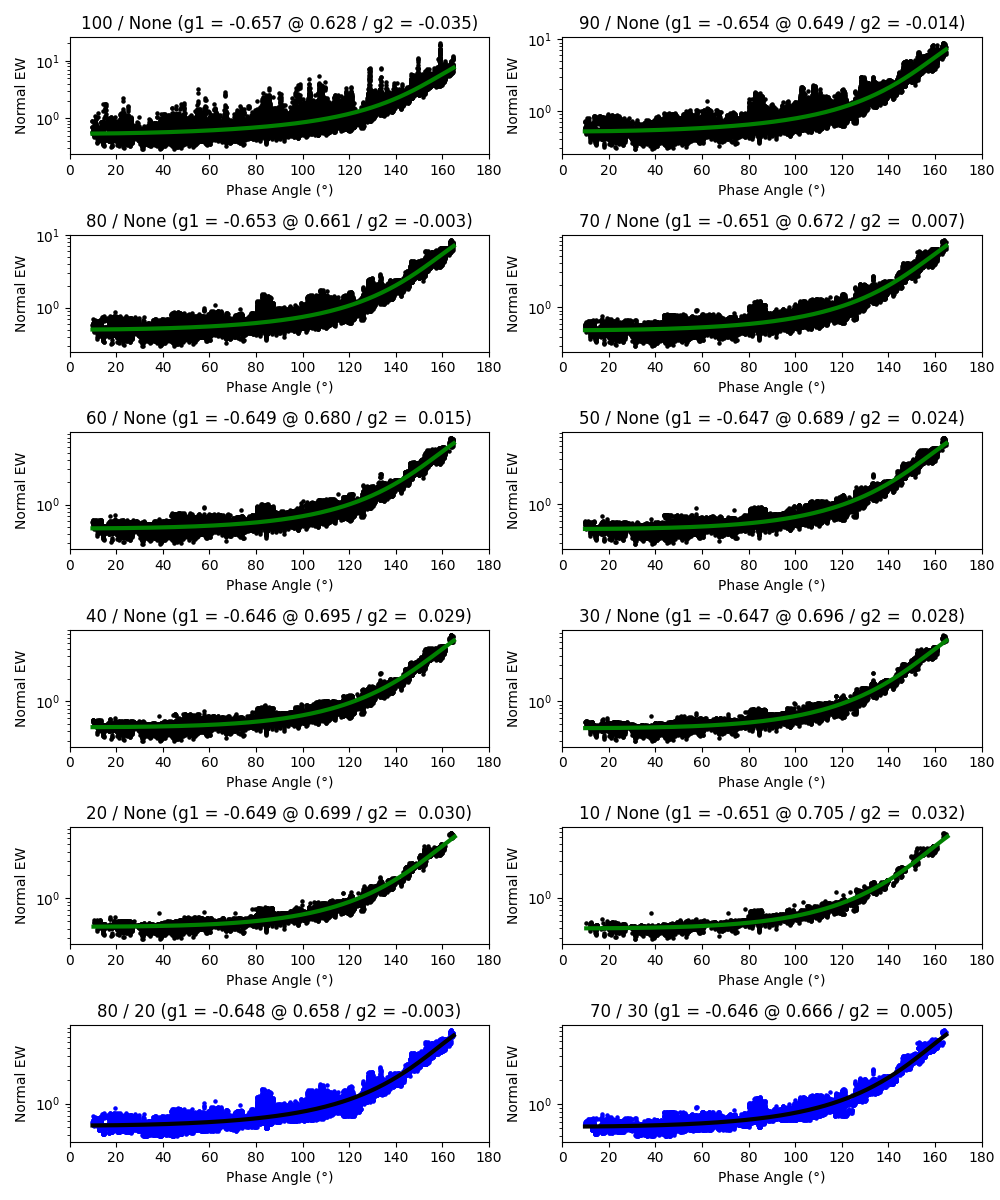

*** 100 / None: black
g1 = -0.657 / scale1 =  1.643 / weight1 = 0.628 
g2 = -0.035 / scale2 =  0.972 / weight2 = 0.372  Avg scale 1.308
g1 = -0.684 / scale1 =  1.603 / weight1 = 0.607 
g2 = -0.048 / scale2 =  1.040 / weight2 = 0.393  Avg scale 1.321
*** 90 / None: black
g1 = -0.654 / scale1 =  1.598 / weight1 = 0.649 
g2 = -0.014 / scale2 =  0.863 / weight2 = 0.351  Avg scale 1.230
g1 = -0.678 / scale1 =  1.571 / weight1 = 0.627 
g2 = -0.034 / scale2 =  0.936 / weight2 = 0.373  Avg scale 1.254
*** 80 / None: black
g1 = -0.653 / scale1 =  1.573 / weight1 = 0.661 
g2 = -0.003 / scale2 =  0.806 / weight2 = 0.339  Avg scale 1.189
g1 = -0.678 / scale1 =  1.549 / weight1 = 0.636 
g2 = -0.028 / scale2 =  0.887 / weight2 = 0.364  Avg scale 1.218
*** 70 / None: black
g1 = -0.651 / scale1 =  1.554 / weight1 = 0.672 
g2 =  0.007 / scale2 =  0.758 / weight2 = 0.328  Avg scale 1.156
g1 = -0.675 / scale1 =  1.536 / weight1 = 0.646 
g2 = -0.020 / scale2 =  0.840 / weight2 = 0.354  Avg scale 1.188
***

In [4]:
plot_various_quants(obsdata_0_1)

# Check for Time Variation

1 degree slices, 100% cutoff
g1 = -0.657 / scale1 =  1.643 / weight1 = 0.628 
g2 = -0.035 / scale2 =  0.972 / weight2 = 0.372  Avg scale 1.308


<IPython.core.display.Javascript object>


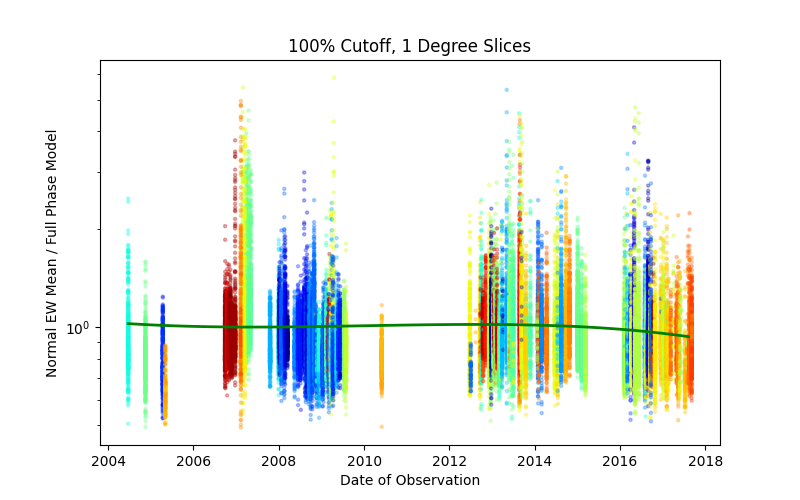

In [5]:
cutoff = 100
obsdata_limited = limit_by_quant(obsdata_0_1, cutoff, None)
params_limited, _, _ = fit_hg_phase_function(2, None, obsdata_limited)
print(f'1 degree slices, {cutoff}% cutoff')
print_hg_params(params_limited)
plot_points_phase_time(obsdata_0_1, params_limited, title=f'{cutoff}% Cutoff, 1 Degree Slices', time_fit=3)